# Part 1: The spelled-out intro to neural networks and backpropagation: building micrograd

In [15]:
# derivatives
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

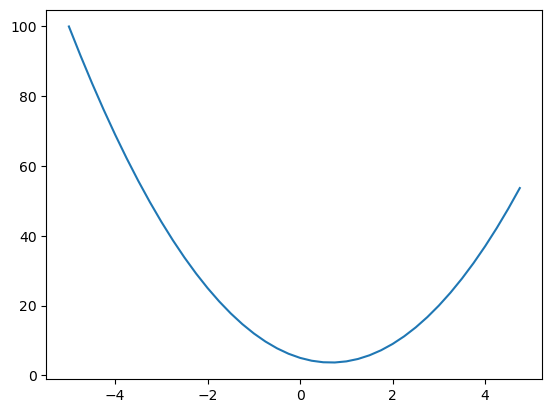

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [7]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)



d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [71]:
class Value:
    
    def __init__(self, data, _children=(), _op=' ', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
            
    
    def __neg__(self):
        return self * -1

            
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label ='d'
f = Value(-2.0, label='f')
L = d * f ; L.label='L'
L

Value(data=-8.0)

In [10]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [11]:
d._op

'+'

In [39]:
from graphviz import Digraph

# does not quite give the same result, but did not debug

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

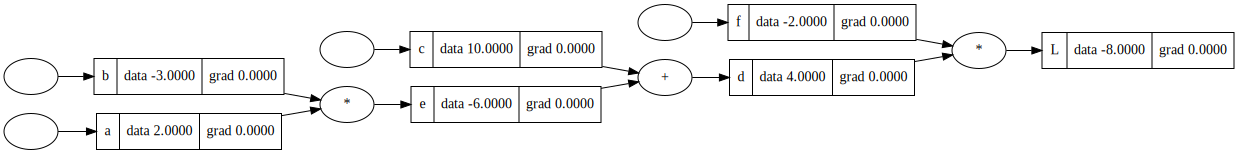

In [13]:
draw_dot(L)

In [14]:
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label ='d'
    f = Value(-2.0, label='f')
    L = d * f ; L.label='L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label ='d'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data
    
    print((L2-L1)/h)

lol()
    

4.000000000017323


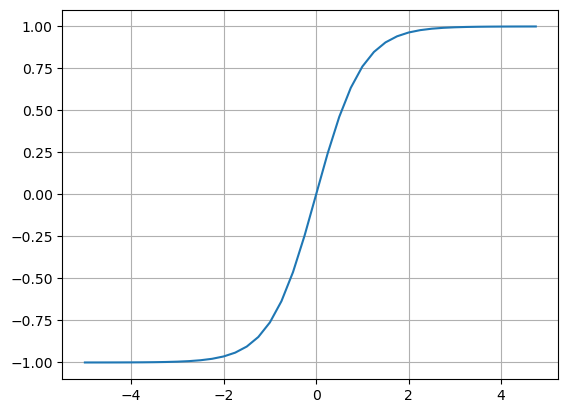

In [15]:
plt.plot(xs, np.tanh(xs)); plt.grid();

In [64]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88137, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


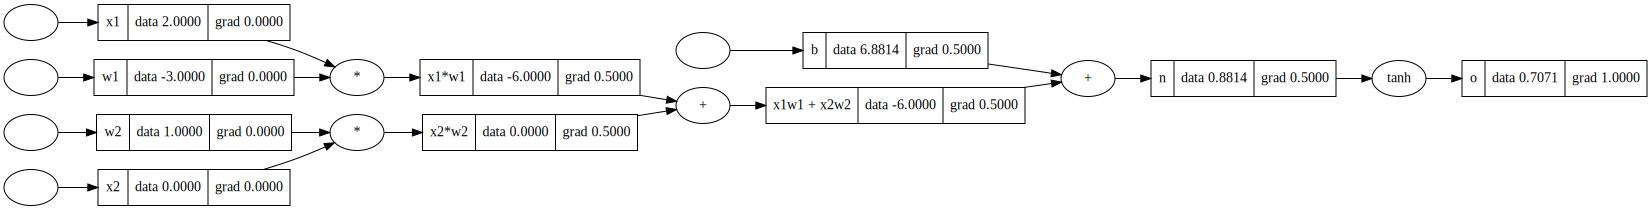

In [30]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5



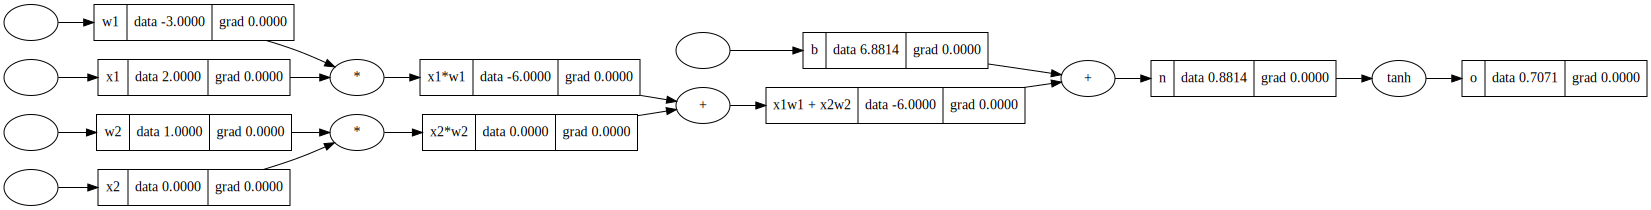

In [54]:
draw_dot(o)

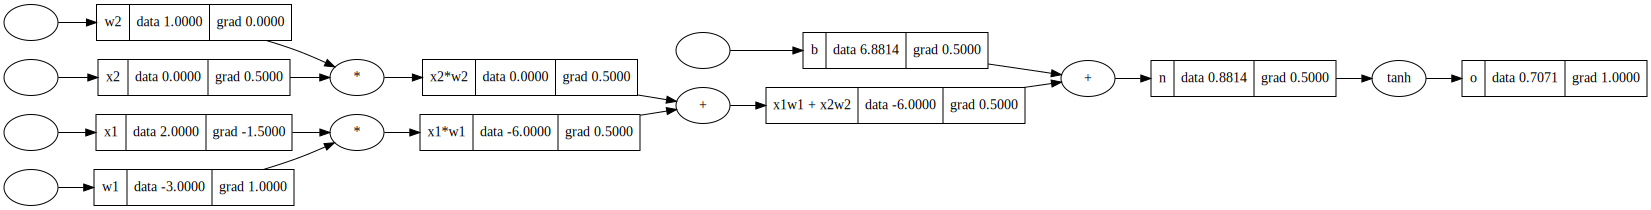

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

draw_dot(o)

In [52]:
# topological sort of directed acyclic graph ?
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.88137),
 Value(data=0.8813700000000004),
 Value(data=0.7071049876722272)]

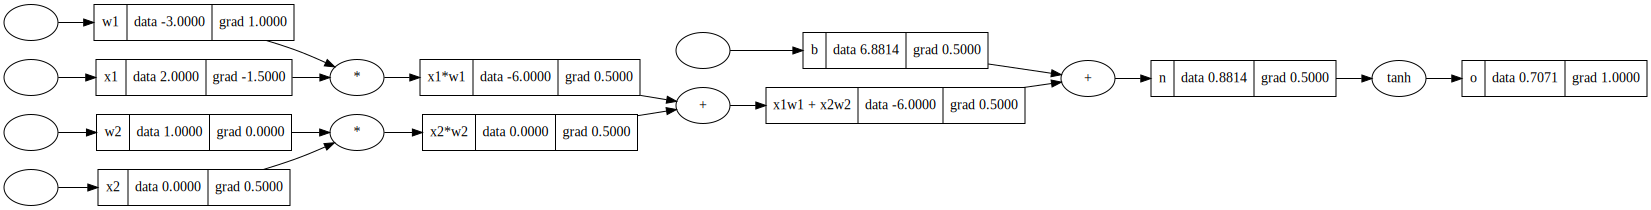

In [57]:
o.grad=1.0

build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

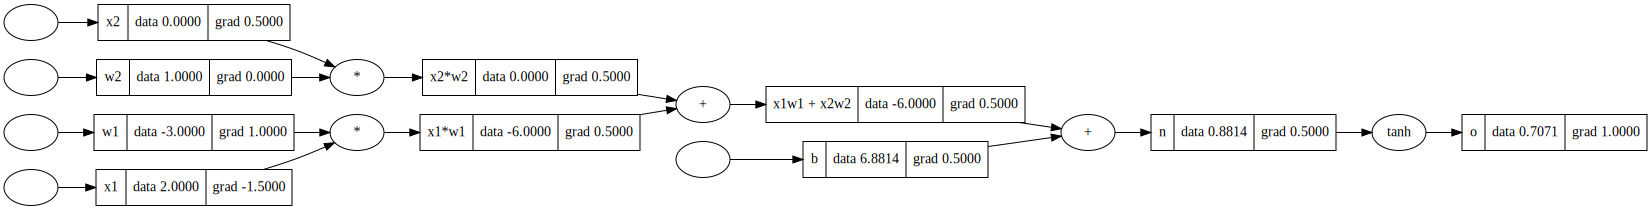

In [65]:
o.backward()
draw_dot(o)

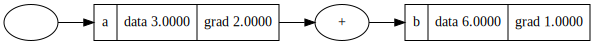

In [66]:
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [75]:
a = Value(2.0)
a * 2
2 * a

Value(data=4.0)

In [108]:
a = Value(2.0)
b = a.exp()
b._backward()
b.grad=1
a.grad

0.0

In [110]:
a = Value(2.0)
b = Value(4.0)
a / b

# stopped around 1:37

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [7]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())

o.backward()

print('-------')
print('x2', x2.grad)
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071050214706146
-------
x2 tensor([0.5000], dtype=torch.float64)
w2 0.0
x1 -1.500007465833125
w1 1.0000049772220834


In [86]:
# Neuron

import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # forward pass, write n(x) = sum w x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.986990614546409)

In [87]:
# Layer of neuron

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
x = [2.0, 3.0]
n = Layer(2,3)
n(x)
n.neurons

In [142]:
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return(x)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.42789027236552224)

In [75]:
# draw_dot(n(x))

In [129]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [203]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9998257028116327),
 Value(data=-0.9995027141783629),
 Value(data=-0.997755529952084),
 Value(data=0.9994825448123799)]

In [204]:

loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.5830783654608335e-06)

In [205]:
loss.backward()

In [206]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [254]:
n = MLP(3, [4,4,1])

for k in range(20):
    #forward
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    #backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.2 * p.grad
    
    print(k, loss.data)
    
    
    

0 3.541527828568075
1 2.578919679834604
2 7.988739260034627
3 7.9882696780619735
4 7.987759647814093
5 7.987203742643555
6 7.986595525259514
7 7.985927302187074
8 7.985189803332032
9 7.984371758695318
10 7.98345933173764
11 7.9824353496708795
12 7.981278240864452
13 7.979960541356208
14 7.978446753231522
15 7.976690203607223
16 7.974628318774515
17 7.97217530362343
18 7.969210414417459
19 7.965558422538864
